In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import json
from datetime import datetime
import warnings

In [2]:
cache_dir="..\\data\\"

In [3]:
results_dir = os.path.join(cache_dir, "results", "dendrite-clean-subclass")
results_files = os.listdir(results_dir)
results_json_files = [f for f in results_files if f.endswith(".json")]
studied = set([int(f[:18]) for f in results_json_files])
studied_str = str(len(studied))  # "_".join(map(str, studied))
results_fname = f"{studied_str}_extended_proofread_cells"
studied

{864691134884807418,
 864691134988722810,
 864691134988768122,
 864691135117980637,
 864691135272206865,
 864691135293126156,
 864691135415666362,
 864691135497743635,
 864691135517531786,
 864691135583884664,
 864691135815579983,
 864691135884023664,
 864691135937286404,
 864691135975539779,
 864691136008689326,
 864691136039640318,
 864691136108938168,
 864691136227167569,
 864691136309871706,
 864691136812081779}

# Gather results

In [4]:
inh_cell_types = ['BC', 'MC', 'BPC', 'NGC']
cell_types = ['exc'] + inh_cell_types

# results
p_post_syn_type_given_pre_23P = dict([(cell_type, 0.0) for cell_type in inh_cell_types])
p_post_syn_type_given_pre_23Ps = dict()
ns = dict()
n = 0
all_euc_hists = dict()
all_path_hists = dict()
all_euc_densities = dict()
all_path_densities = dict()
clean_output_df = pd.DataFrame()
syn_dfs = dict((t, pd.DataFrame()) for t in cell_types)

for root_id in studied:
    possible_current_json_files = [f for f in results_json_files if f.startswith(str(root_id))]  # the jsons of the desired cell
    current_json_file = sorted(possible_current_json_files)[-1]  # should only be one, but if more than one, pick the most recent 
    with open(os.path.join(results_dir, current_json_file)) as f:
        data = json.loads(f.read())
    
    clean_output_df = pd.concat([clean_output_df, pd.DataFrame(data["clean_output_dict"])], axis=0)
    for cell_type in cell_types:
         syn_dfs[cell_type] = pd.concat([syn_dfs[cell_type], pd.DataFrame(data["syn_dicts"][cell_type])], axis=0)
    current_n = data["post_syn_BPC_given_pre_23P"]["n"]  # all of them have the same n
    n += current_n
    ns[root_id] = current_n
    p_post_syn_type_given_pre_23Ps[root_id] = dict()
    for cell_type in inh_cell_types:
        p_post_syn_type_given_pre_23P[cell_type] += data[f"post_syn_{cell_type}_given_pre_23P"]["p"] * current_n
        p_post_syn_type_given_pre_23Ps[root_id][cell_type] = data[f"post_syn_{cell_type}_given_pre_23P"]["p"]
    all_euc_hists[root_id] = pd.DataFrame(data["euc_hists"])
    all_path_hists[root_id] = pd.DataFrame(data["path_hists"])
    all_euc_densities[root_id] = pd.DataFrame(data["euc_densities"])
    all_path_densities[root_id] = pd.DataFrame(data["path_densities"])
        
    # parameters should all be the same, so we'll just use the last ones
    params = data["parameters"]
    max_hist_dist = params["max_hist_dist"]
    path_dist_step = params["path_dist_step"]
    euc_dist_step = params["euc_dist_step"]
    
p_post_syn_type_given_pre_23P = dict([(c, p_post_syn_type_given_pre_23P[c] / n) for c in p_post_syn_type_given_pre_23P])
p_post_syn_inh_given_pre_23P = sum(p_post_syn_type_given_pre_23P.values())

In [5]:
euc_hists = sum(all_euc_hists.values())
path_hists = sum(all_path_hists.values())
euc_densities = sum(all_euc_densities.values()) / len(studied)
path_densities = sum(all_path_densities.values()) / len(studied)

## Results and Figures!

In [6]:
path_bin_edges = np.arange(0, max_hist_dist, path_dist_step)
path_bin_centers = (path_bin_edges[1:] + path_bin_edges[:-1]) / 2

euc_bin_edges = np.arange(0, max_hist_dist, euc_dist_step)
euc_bin_centers = (path_bin_edges[1:] + path_bin_edges[:-1]) / 2

In [7]:
# continuously moving bucket to calculate synapse density of each type
# this implementation is a bit slow, but it's not that big a deal
# (I should rather loop over the synapses and increment appropriate counters as I go)
nsteps = 1000  # whoops this (unimportant) parameter wasn't saved, so we have to stick with it
euc_bin_locs = np.linspace(euc_dist_step / 2, max_hist_dist - euc_dist_step / 2, nsteps)
path_bin_locs = np.linspace(path_dist_step / 2, max_hist_dist - path_dist_step / 2, nsteps)

In [8]:
p_type_by_path_dists = dict()
path_total_density = sum(path_densities[t] for t in path_densities)
for cell_type in path_densities:
    p_type_by_path_dists[cell_type] = path_densities[cell_type] / path_total_density
p_type_by_euc_dists = dict()
euc_total_density = sum(euc_densities[t] for t in euc_densities)
for cell_type in euc_densities:
    p_type_by_euc_dists[cell_type] = euc_densities[cell_type] / euc_total_density
    
all_p_type_by_path_dists = dict((cell_id, dict()) for cell_id in studied)
all_p_type_by_euc_dists = dict((cell_id, dict()) for cell_id in studied)
all_path_total_density = dict()
all_euc_total_density = dict()
for cell_id in studied:
    all_path_total_density[cell_id] = sum(all_path_densities[cell_id][t] for t in all_path_densities[cell_id])
    for cell_type in all_path_densities[cell_id]:
        all_p_type_by_path_dists[cell_id][cell_type] = all_path_densities[cell_id][cell_type] / all_path_total_density[cell_id]
    all_euc_total_density[cell_id] = sum(all_euc_densities[cell_id][t] for t in all_euc_densities[cell_id])
    for cell_type in all_euc_densities[cell_id]:
        all_p_type_by_euc_dists[cell_id][cell_type] = all_euc_densities[cell_id][cell_type] / all_euc_total_density[cell_id]

In [9]:
plot_colors = ["lime", "gold", "orangered", "darkorchid", "dodgerblue"]
type_colors = dict(zip(cell_types, plot_colors))

In [12]:
plt.pie?

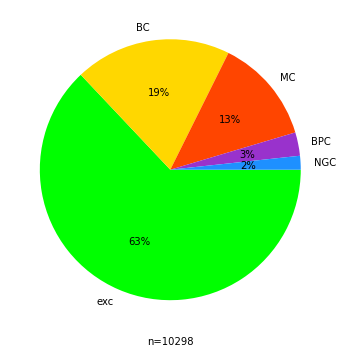

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))
inh_ps = list(p_post_syn_type_given_pre_23P.values())
ps = [1 - sum(inh_ps)] + inh_ps
ax.pie(ps, labels=cell_types, colors=plot_colors, autopct=lambda p: str(round(p)) + "%", counterclock=False)
ax.set_xlabel("n=" + str(n))
plt.show()

In [14]:
fig.savefig(os.path.join(cache_dir, "results", "subclass", results_fname + "_pie.png"))

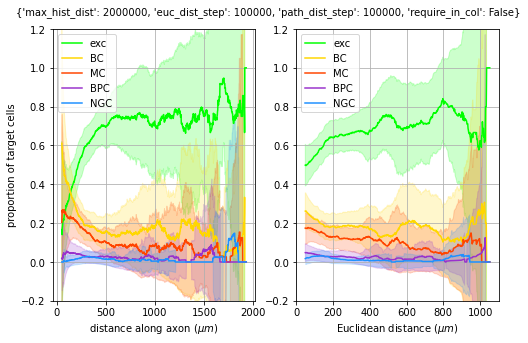

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5))
for cell_type in cell_types:
    p = p_type_by_path_dists[cell_type]
    axes[0].plot(path_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
    std_hat = np.sqrt(p * (1 - p) / (path_dist_step * path_total_density))
    axes[0].fill_between(path_bin_locs/1000, p - 2 * std_hat, p + 2 * std_hat, color=type_colors[cell_type], alpha=0.2)
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].set_ylabel("proportion of target cells")
axes[0].legend()
axes[0].grid()
axes[0].set_ylim((-0.2, 1.2))
for cell_type in cell_types:
    p = p_type_by_euc_dists[cell_type]
    axes[1].plot(euc_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
    std_hat = np.sqrt(p * (1 - p) / (euc_dist_step * euc_total_density))
    axes[1].fill_between(euc_bin_locs/1000, p - 2 * std_hat, p + 2 * std_hat, color=type_colors[cell_type], alpha=0.2)
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].legend()
axes[1].grid()
axes[1].set_ylim((-0.2, 1.2))
fig.text(.5, 0.92, str(params), ha="center")
plt.show()

In [16]:
fig.savefig(os.path.join(results_dir, results_fname + "_p_type.png"))

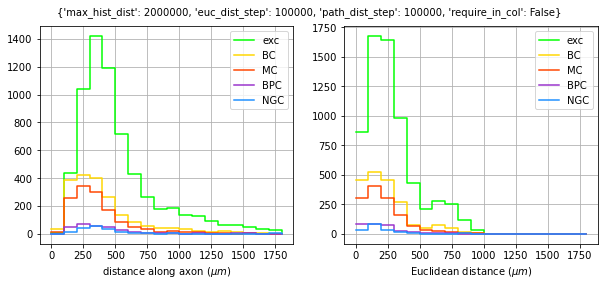

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for cell_type in cell_types:
    axes[0].step(path_bin_edges[:-1]/1000, path_hists[cell_type], color=type_colors[cell_type], label=cell_type, where="post")
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].legend()
axes[0].grid()
for cell_type in cell_types:
    axes[1].step(euc_bin_edges[:-1]/1000, euc_hists[cell_type], color=type_colors[cell_type], label=cell_type, where="post")
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].legend()
axes[1].grid()
fig.text(.5, 0.92, str(params), ha="center")
plt.show()

In [18]:
fig.savefig(os.path.join(results_dir, results_fname + "_hists.png"))

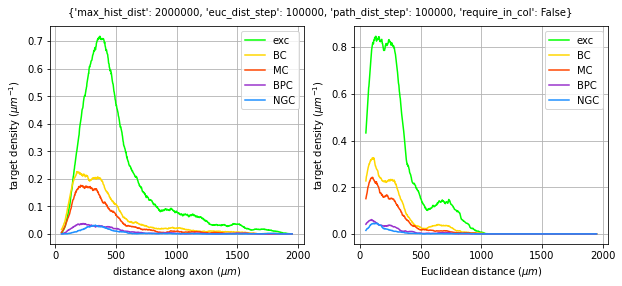

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for cell_type in cell_types:
    axes[0].plot(path_bin_locs/1000, 1000*path_densities[cell_type], color=type_colors[cell_type], label=cell_type)
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].set_ylabel("target density ($\mu m^{-1}$)")
axes[0].legend()
axes[0].grid()
for cell_type in cell_types:
    axes[1].plot(euc_bin_locs/1000, 1000*euc_densities[cell_type], color=type_colors[cell_type], label=cell_type)
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].set_ylabel("target density ($\mu m^{-1}$)")
axes[1].legend()
axes[1].grid()
fig.text(.5, 0.92, str(params), ha="center")
plt.show()

In [20]:
fig.savefig(os.path.join(results_dir, results_fname + "_densities.png"))

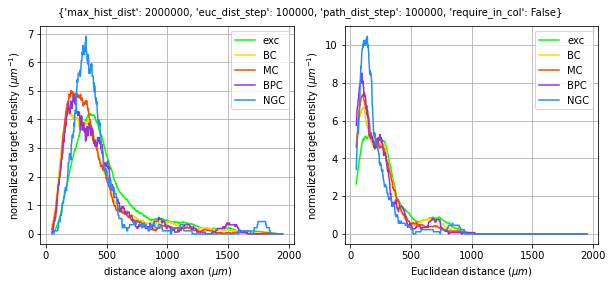

In [21]:
# normalized
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for cell_type in cell_types:
    d = path_densities[cell_type]
    d /= np.mean(d)
    axes[0].plot(path_bin_locs/1000, d, color=type_colors[cell_type], label=cell_type)
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].set_ylabel("normalized target density ($\mu m^{-1}$)")
axes[0].legend()
axes[0].grid()
for cell_type in cell_types:
    d = euc_densities[cell_type]
    d /= np.mean(d)
    axes[1].plot(euc_bin_locs/1000, d, color=type_colors[cell_type], label=cell_type)
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].set_ylabel("normalized target density ($\mu m^{-1}$)")
axes[1].legend()
axes[1].grid()
fig.text(.5, 0.92, str(params), ha="center")
plt.show()

In [22]:
fig.savefig(os.path.join(results_dir, results_fname + "_normalized_densities.png"))

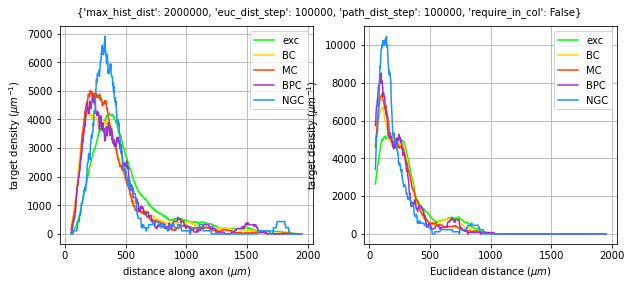

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for cell_type in cell_types:
    axes[0].plot(path_bin_locs/1000, 1000*path_densities[cell_type], color=type_colors[cell_type], label=cell_type)
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].set_ylabel("target density ($\mu m^{-1}$)")
axes[0].legend()
axes[0].grid()
for cell_type in cell_types:
    axes[1].plot(euc_bin_locs/1000, 1000*euc_densities[cell_type], color=type_colors[cell_type], label=cell_type)
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].set_ylabel("target density ($\mu m^{-1}$)")
axes[1].legend()
axes[1].grid()
fig.text(.5, 0.92, str(params), ha="center")
plt.show()

In [24]:
fig.savefig(os.path.join(results_dir, results_fname + "_densities.png"))

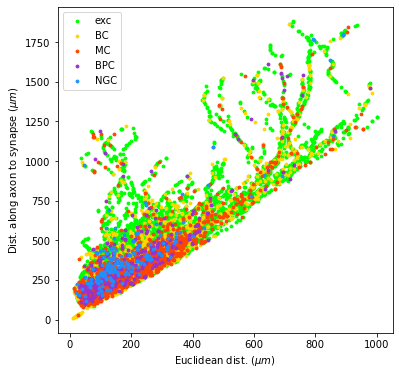

In [25]:
# plot euclidean distance to synapse vs path distance to synapse
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].euc_dist / 1000, syn_dfs[cell_type].path_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
ax.set_xlabel("Euclidean dist. ($\mu m$)")
ax.set_ylabel("Dist. along axon to synapse ($\mu m$)")
plt.legend()
plt.show()

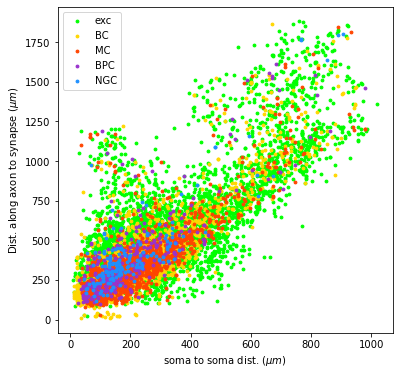

In [26]:
# plot path-distance along axon to synapse vs distance from pre-soma to post-soma
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].soma_to_soma_dist / 1000, syn_dfs[cell_type].path_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
ax.set_xlabel("soma to soma dist. ($\mu m$)")
ax.set_ylabel("Dist. along axon to synapse ($\mu m$)")
plt.legend()
plt.show()

In [27]:
fig.savefig(os.path.join(results_dir, results_fname + "_soma-soma_v_path.png"))

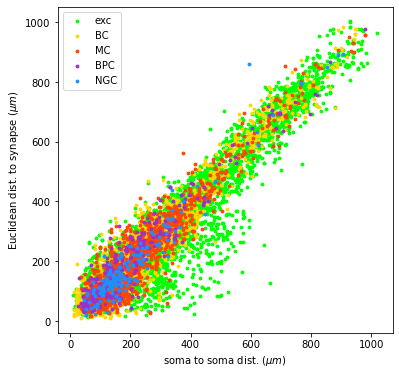

In [28]:
# plot euclidean distance to synapse vs distance from pre-soma to post-soma
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].soma_to_soma_dist / 1000, syn_dfs[cell_type].euc_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
ax.set_xlabel("soma to soma dist. ($\mu m$)")
ax.set_ylabel("Euclidean dist. to synapse ($\mu m$)")
plt.legend()
plt.show()

In [29]:
fig.savefig(os.path.join(results_dir, results_fname + "_soma-soma_v_euc.png"))

## All of them at once

C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  """
C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  # Remove the CWD from sys.path while we load stuff.


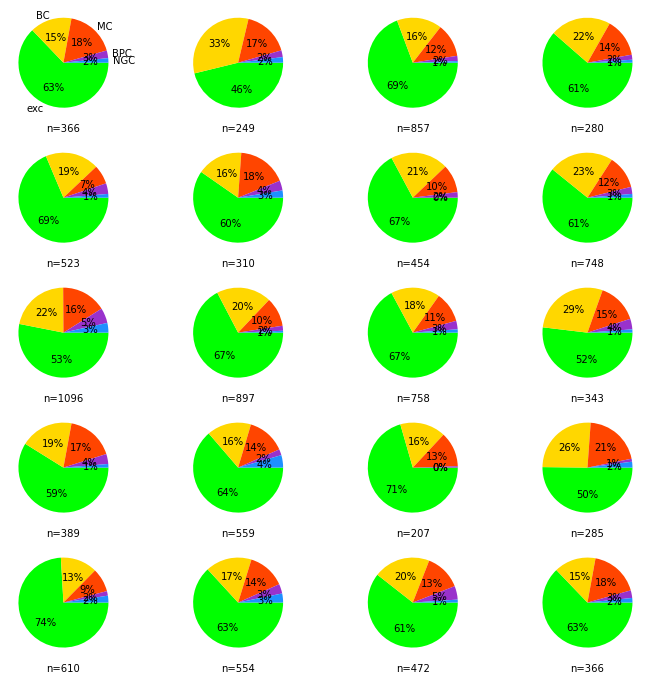

<Figure size 432x288 with 0 Axes>

In [32]:
fig, axes = plt.subplots(5, 4, figsize=(12, 12))
axes = axes.flatten()
inh_ps = list(p_post_syn_type_given_pre_23Ps[cell_id].values())
ps = [1 - sum(inh_ps)] + inh_ps
axes[0].pie(ps, labels=cell_types, colors=plot_colors, autopct=lambda p: str(round(p)) + "%", counterclock=False)
axes[0].set_xlabel("n=" + str(ns[cell_id]))
for i, cell_id in list(enumerate(studied))[1:]:
    inh_ps = list(p_post_syn_type_given_pre_23Ps[cell_id].values())
    ps = [1 - sum(inh_ps)] + inh_ps
    axes[i].pie(ps, colors=plot_colors, autopct=lambda p: str(round(p)) + "%", pctdistance=0.6, counterclock=False)
    axes[i].set_xlabel("n=" + str(ns[cell_id]))
plt.show()
plt.tight_layout()

In [33]:
fig.savefig(os.path.join(results_dir, results_fname + "_all_pies.png"))

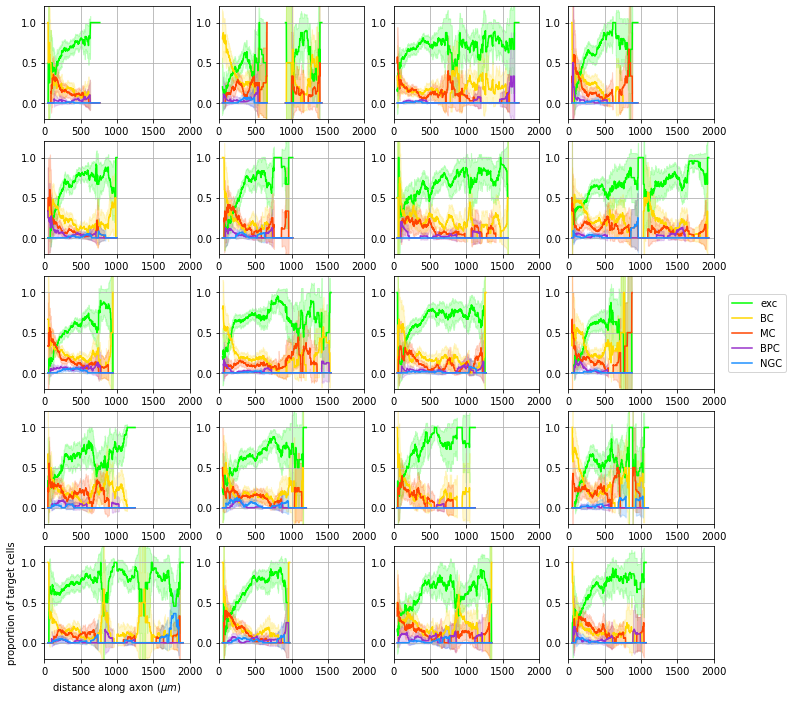

<Figure size 432x288 with 0 Axes>

In [34]:
fig, axes = plt.subplots(5, 4, figsize=(12, 12))
axes = axes.flatten()
for i, cell_id in enumerate(studied):
    for cell_type in cell_types:
        p = all_p_type_by_path_dists[cell_id][cell_type]
        axes[i].plot(path_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
        std_hat = np.sqrt(p * (1 - p) / (path_dist_step * all_path_total_density[cell_id]))
        axes[i].fill_between(path_bin_locs/1000, p - 2 * std_hat, p + 2 * std_hat, color=type_colors[cell_type], alpha=0.2)
#     axes[i].set_title("cell=" + str(cell_id))
    axes[i].grid()
    axes[i].set_ylim((-0.2, 1.2))
    axes[i].set_xlim((0, max_hist_dist/1000))
#     axes[i].set_xticklabels([''] * 4)
# axes[16].set_xticklabels([0, 500, 1000, 1500, 2000])
axes[11].legend(loc=(1.1, 0.15))
axes[16].set_xlabel("distance along axon ($\mu m$)")
axes[16].set_ylabel("proportion of target cells")
plt.show()
plt.tight_layout()

In [35]:
fig.savefig(os.path.join(results_dir, results_fname + "_all_p_types_path.png"))

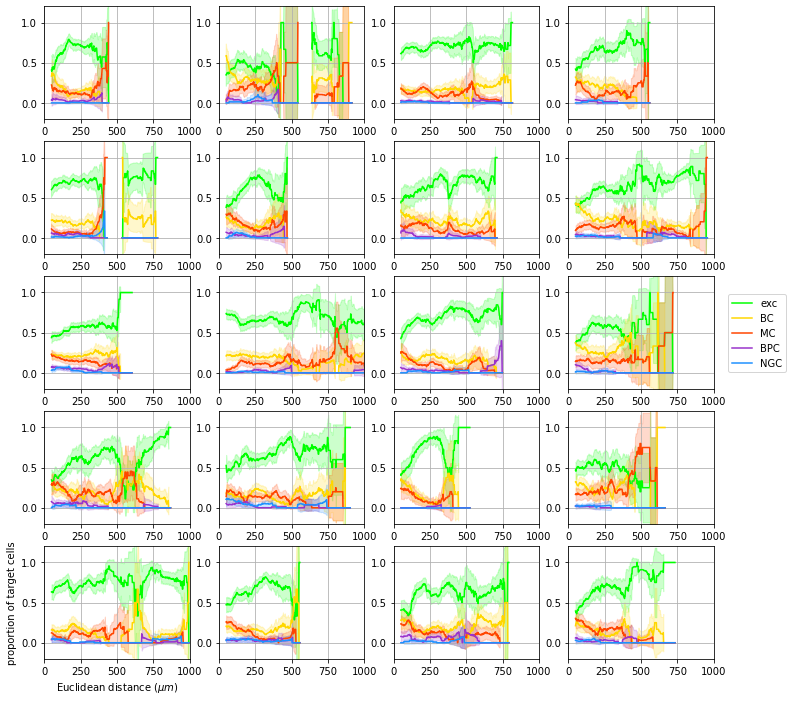

<Figure size 432x288 with 0 Axes>

In [36]:
fig, axes = plt.subplots(5, 4, figsize=(12, 12))
axes = axes.flatten()
for i, cell_id in enumerate(studied):
    for cell_type in cell_types:
        p = all_p_type_by_euc_dists[cell_id][cell_type]
        axes[i].plot(euc_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
        std_hat = np.sqrt(p * (1 - p) / (euc_dist_step * all_euc_total_density[cell_id]))
        axes[i].fill_between(euc_bin_locs/1000, p - 2 * std_hat, p + 2 * std_hat, color=type_colors[cell_type], alpha=0.2)
    axes[i].grid()
    axes[i].set_ylim((-0.2, 1.2))
    axes[i].set_xlim((0, max_hist_dist/2000))
axes[11].legend(loc=(1.1, 0.15))
axes[16].set_xlabel("Euclidean distance ($\mu m$)")
axes[16].set_ylabel("proportion of target cells")
plt.show()
plt.tight_layout()

In [37]:
fig.savefig(os.path.join(results_dir, results_fname + "_all_p_types_euc.png"))

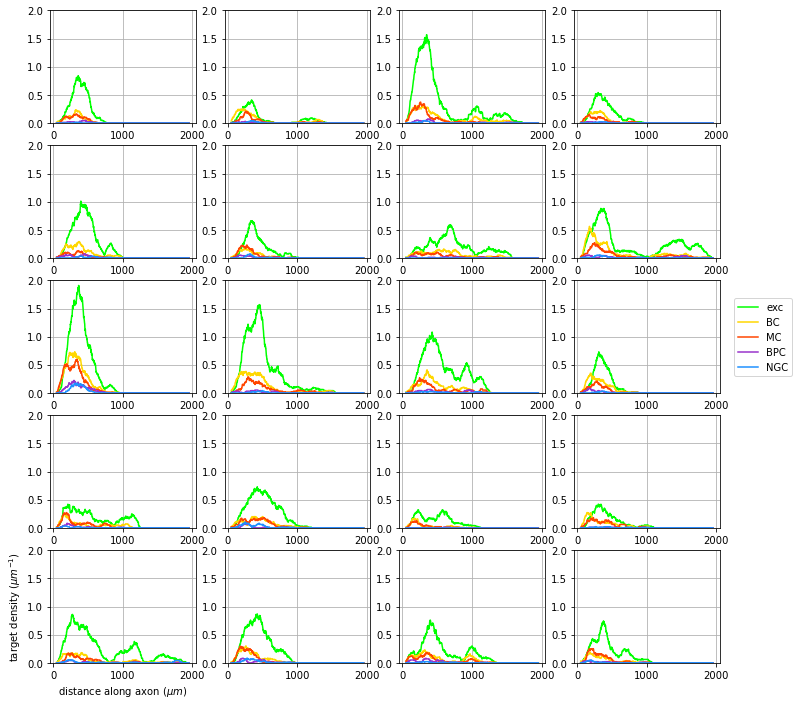

<Figure size 432x288 with 0 Axes>

In [38]:
fig, axes = plt.subplots(5, 4, figsize=(12, 12))
axes = axes.flatten()
for i, cell_id in enumerate(studied):
    for cell_type in cell_types:
        axes[i].plot(path_bin_locs/1000, 1000*all_path_densities[cell_id][cell_type], color=type_colors[cell_type], label=cell_type)
    axes[i].grid()
    axes[i].set_ylim((0, 2))
axes[11].legend(loc=(1.1, 0.15))
axes[16].set_xlabel("distance along axon ($\mu m$)")
axes[16].set_ylabel("target density ($\mu m^{-1}$)")
plt.show()
plt.tight_layout()

In [39]:
fig.savefig(os.path.join(results_dir, results_fname + "_all_densities_path.png"))

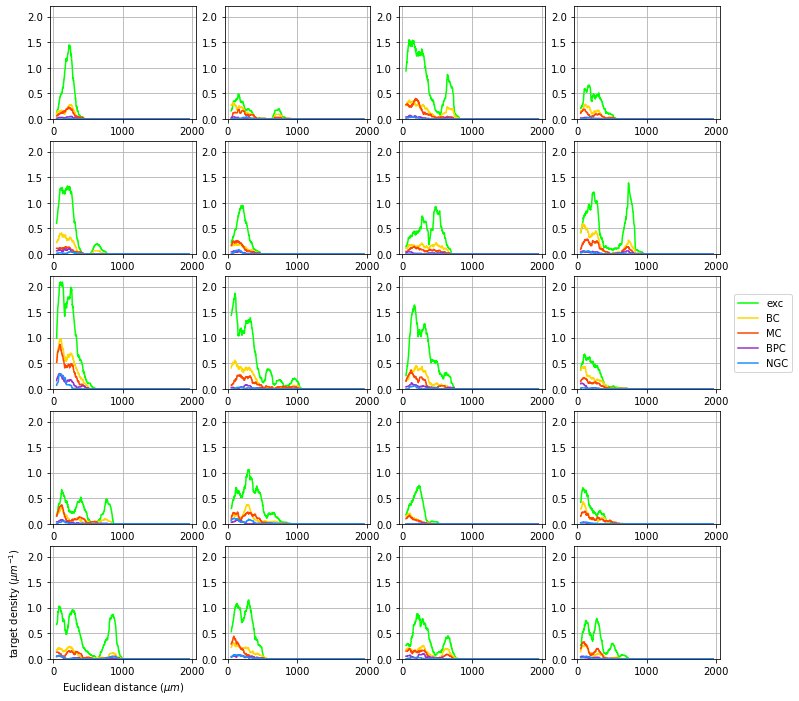

<Figure size 432x288 with 0 Axes>

In [40]:
fig, axes = plt.subplots(5, 4, figsize=(12, 12))
axes = axes.flatten()
for i, cell_id in enumerate(studied):
    for cell_type in cell_types:
        axes[i].plot(euc_bin_locs/1000, 1000*all_euc_densities[cell_id][cell_type], color=type_colors[cell_type], label=cell_type)
    axes[i].grid()
    axes[i].set_ylim((0, 2.2))
axes[11].legend(loc=(1.1, 0.15))
axes[16].set_xlabel("Euclidean distance ($\mu m$)")
axes[16].set_ylabel("target density ($\mu m^{-1}$)")
plt.show()
plt.tight_layout()

In [41]:
fig.savefig(os.path.join(results_dir, results_fname + "_all_densities_euc.png"))